In [103]:
from scipy.io import loadmat
import proplot as pplt
import pandas as pd
import numpy as np
import sys
sys.path.append('../../drifter')
from importlib import reload
import utilities.cleaning
utilities.cleaning = reload(utilities.cleaning)

In [6]:
clean_data = loadmat('../data/IABP2010.mat')['IABP2010']

In [140]:
idx = 0
buoy0 = pd.DataFrame({c: np.concatenate(ndata[c][idx]) for c in clean_data.dtype.names[1:]})
buoy0['id'] = buoy0['id'].astype(int)
buoy0['date'] = pd.Series([pd.to_datetime(str(y) + '-01-01 00:00') + pd.to_timedelta(x, unit='days') 
              for x, y in zip(buoy0.yday, buoy0.year)]).round('1min')
buoy0.rename({'lat': 'latitude',
              'lon': 'longitude'}, axis=1, inplace=True)
buoy0.to_csv('../tests/test_duplicates.csv')

In [104]:
testdf = pd.read_csv('../data/test_duplicates.csv', index_col=0)
testdf['date'] = pd.to_datetime(testdf.date.values)
print(testdf.info())
testdf['test_flag'] = utilities.cleaning.flag_duplicates(testdf)
#assert testdf.test_flag.sum() == testdf.flag.sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3259 entries, 0 to 3258
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         3259 non-null   int64         
 1   year       3259 non-null   int64         
 2   yday       3259 non-null   float64       
 3   datenum    3259 non-null   float64       
 4   latitude   3259 non-null   float64       
 5   longitude  3259 non-null   float64       
 6   flag       3259 non-null   int64         
 7   date       3259 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 229.1 KB
None
       id  year    yday     datenum  latitude  longitude  flag  \
0  100009  2010  35.875  734173.875    81.743     -3.247     0   
1  100009  2010  35.917  734173.917    81.741     -3.247     1   
2  100009  2010  35.958  734173.958    81.738     -3.249     0   
3  100009  2010  36.000  734174.000    81.736     -3.251     0   
4  100009  2010  3

<a list of 1 Line2D objects>

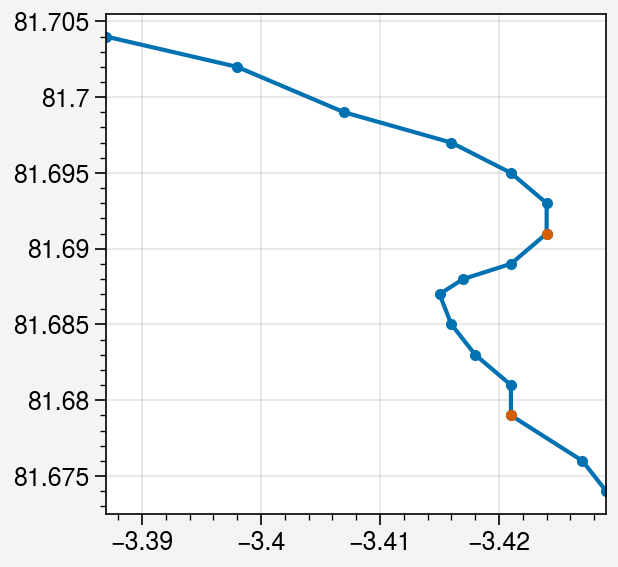

In [105]:
data = testdf.loc[25:40]
fig, ax = pplt.subplots()
ax.plot(data['longitude'].values, data['latitude'].values, marker='.')
ax.plot(data['longitude'].where(data['flag']==1).values,
        data['latitude'].where(data['flag']==1).values, marker='.')
ax.plot(data['longitude'].where(data['test_flag']).values,
        data['latitude'].where(data['test_flag']).values, marker='o', edgecolor='k', facecolor=None)

So far: there are a few instances where there are repeated longitudes and nonrepeated latitudes, which could be right or could be wrong. Since it doesn't look like time is moving backwards on these, let's check if those points got flagged for having too high of speeds.

In [106]:
import pyproj as proj

In [107]:
projIn = 'epsg:4326' # WGS 84 Ellipsoid
projOut = 'epsg:3571' # Lambert Azimuthal Equal Area centered at north pole, lon0 is 180
transformer = proj.Transformer.from_crs(projIn, projOut, always_xy=True)

lon = testdf.longitude
lat = testdf.latitude

x, y = transformer.transform(lon, lat)
testdf['x'] = x
testdf['y'] = y

dt = (testdf.date.shift(-1) - testdf.date.shift(1)).dt.total_seconds()

def centered_velocity(xvar, yvar, data, dt=3600):
    """Assumes the rows are a datetime index with 30 min step size."""
    dx = data[xvar].shift(-1) - data[xvar].shift(1)
    dy = data[yvar].shift(-1) - data[yvar].shift(1)
    return dx/dt, dy/dt

dxdt, dydt = centered_velocity('x', 'y', testdf, dt)
testdf['u'] = dxdt
testdf['v'] = dydt
testdf['speed'] = np.sqrt(testdf['v']**2 + testdf['u']**2)

ddxddt, ddyddt = centered_velocity('u', 'v', testdf, dt)
testdf['du'] = ddxddt
testdf['dv'] = ddyddt
testdf['accel'] = np.sqrt(ddxddt**2 + ddyddt**2)

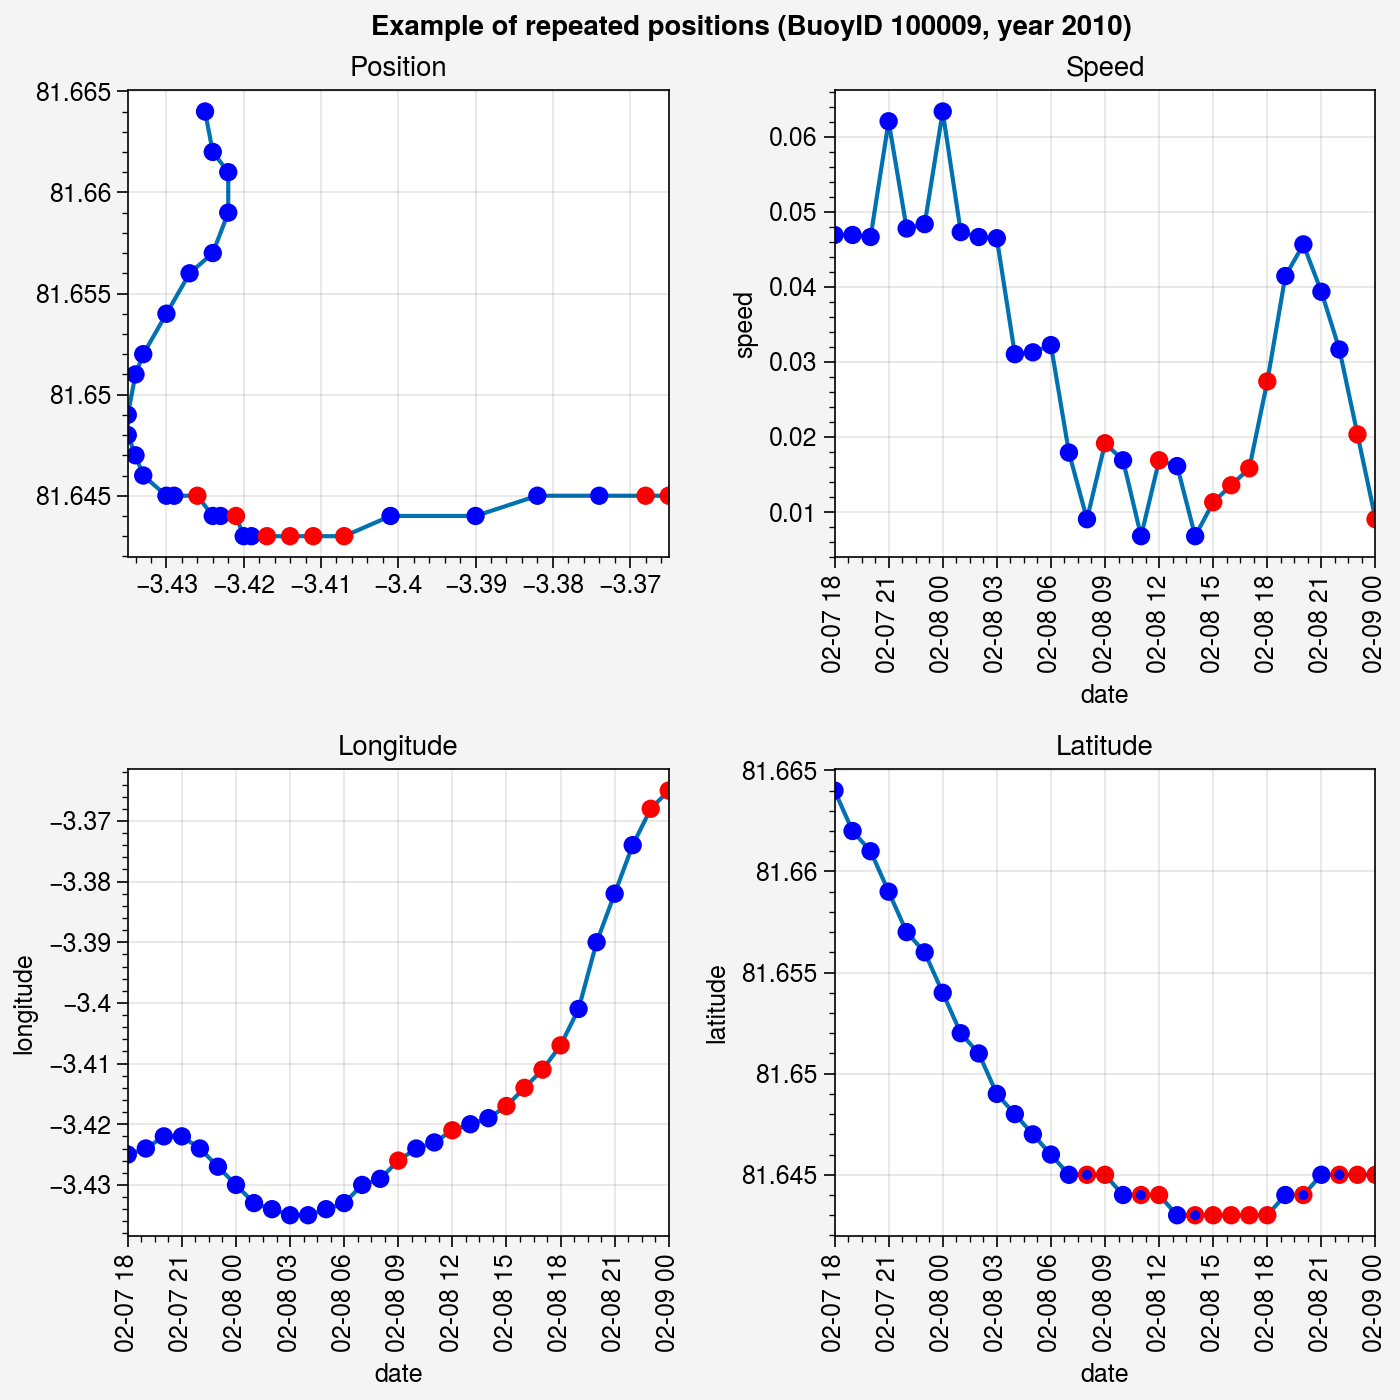

In [125]:
data = testdf.loc[45:75]
fig, axs = pplt.subplots(width=7, height=7, ncols=2, nrows=2, share=False)

ax = axs[0, 0]
ax.plot(data['longitude'].values, data['latitude'].values, marker='.', zorder=0)
ax.scatter(data['longitude'].values, data['latitude'].values, marker='o', c=data['test_flag'], cmap='bwr', zorder=1)
ax.format(title='Position')

ax = axs[1,0]
ax.plot(data['date'].values, data['longitude'].values, zorder=0)
ax.scatter(data['date'], data['longitude'], marker='o', c=data['test_flag'], cmap='bwr', zorder=1)
ax.format(title='Longitude')

ax = axs[1,1]
ax.plot(data['date'].values, data['latitude'].values, zorder=0)
ax.scatter(data['date'], data['latitude'], marker='o', c=data.latitude.shift(1) == data.latitude, cmap='bwr', zorder=1)
ax.scatter(data['date'], data['latitude'], marker='.', c=data.latitude.shift(2) == data.latitude, cmap='bwr', zorder=1)


ax.format(title='Latitude')

ax = axs[0,1]
ax.plot(data['date'].values, data['speed'].values, zorder=0)
ax.scatter(data['date'], data['speed'], marker='o', c=data['test_flag'], cmap='bwr', zorder=1)
ax.format(title='Speed')
ax.format(suptitle='Example of repeated positions (BuoyID 100009, year 2010)')
fig.save('../example_repeated_positions.jpg', dpi=72)

In [123]:
(testdf.latitude.shift(1) == testdf.latitude).sum(), (testdf.latitude.shift(2) == testdf.latitude).sum()

(227, 129)

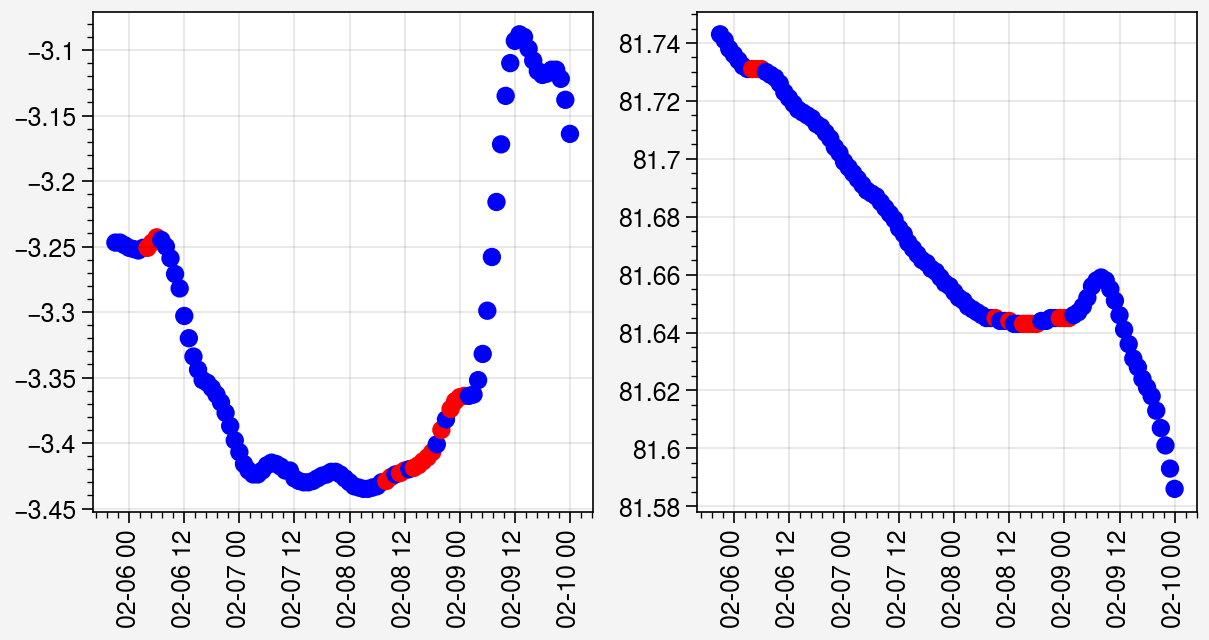

In [122]:
fig, ax = pplt.subplots(share=False, ncols=2)
ax[0].scatter(testdf.date[0:100].values,
           testdf.longitude[0:100].values, c=testdf.latitude[0:100].shift(1) == testdf.latitude[0:100], cmap='bwr')

ax[1].scatter(testdf.date[0:100].values,
           testdf.latitude[0:100].values, c=testdf.test_flag[0:100].astype(int), cmap='bwr')